# **Canada Consumer Price Index (CPI) Analysis**

###### DATA 604-L01
###### BY Natcha Kurupakorn (Judy)

# **Introduction**

The Consumer Price Index (CPI) dataset represents changes in prices as experienced by Canadian consumers over time. It reflects the cost of a fixed basket of goods and services, capturing only pure price changes by maintaining consistent quantity and quality within the basket. The CPI serves as a crucial indicator of inflation, enabling Canadians to evaluate their purchasing power and financial stability by comparing price trends to income changes.

## About Consumer Price Index Data Set

This project leverages CPI data to explore inflation trends and their implications. The dataset, sourced from the Government of Canada and Statistics Canada, is publicly available under the Open Government Licence. With over 1.1 million rows, this extensive dataset provides monthly, not seasonally adjusted data, capturing price changes for various product groups and geographic regions across Canada from 1914 to 2024.

- Format: CSV
- Source: Government of Canada, Statistics Canada. (2024, October 15). Consumer Price Index, monthly, not
seasonally adjusted. https://www150.statcan.gc.ca/t1/tbl1/en/tv.action?pid=1810000401

### Initial Steps
1. **Tools Import and Password Setting:** The required libraries for database connections and data manipulation are imported. Database credentials are securely stored to enable access.

2. **Connection Checking and Exploring Databases:** Connection to the MySQL database is verified, and available databases are reviewed to ensure successful setup.

3. **Source Table Creation:** A source table (t1_source_cpi) is created to store the raw data imported from the CSV file.

4. **CSV Source File Insertion to Table:**
- The CSV dataset is imported into the source table.
- Verification: A comparison is performed to ensure the total records in the database match the original number of records in the CSV file.

5. **Data Wrangling:**
   A target table is created to restructure and refine the data for analysis. Key steps include filtering, column transformations, and generating additional features (**Query_1**).

   For this analysis, data wrangling steps were undertaken to reshape and filter the dataset, ensuring relevance and usability. These steps include filtering records from the year 2000 onwards, removing irrelevant or terminated entries, and adding new columns to enhance interpretability. By focusing on recent trends, this analysis aims to provide valuable insights into Canada's modern economic landscape and inflationary patterns.

### Analysis
1. **Trend of CPI for Provinces Over Time for the All-Items Product Group (Query_2):**
    This analysis focuses on the evolution of the Consumer Price Index (CPI) across Canadian provinces over time, using the "All-Items" product group as a representative measure. This topic is critical as it provides a comprehensive overview of inflationary trends and regional economic conditions.

2. **Analyzing Inflation Trends Pre-, During-, and Post-COVID (Query_3):**
    This analysis delves into the impact of the COVID-19 pandemic on inflation by comparing CPI trends across three distinct periods: before the pandemic, during its peak, and after its resolution. Understanding these patterns is vital for evaluating the pandemic’s economic fallout. The findings could help inform decisions on future crisis management, economic recovery strategies, or long-term planning for maintaining economic stability under similar disruptions.

3. **Impact of Inflation on Essential vs Non-Essential Products (Query_4):**
   This analysis compares the inflation rates of essential products, such as food and utilities, with non-essential items, like luxury goods and recreational services. By differentiating between these categories, this study highlights how inflation affects consumer priorities and purchasing behavior. This information is critical for businesses, policymakers, and social programs to address affordability concerns, ensure access to necessities, and mitigate the economic pressures on households with varying income levels.

4. **Exploration of CPI Trends for Products Relevant to Students (Query_5):**
    This analysis focuses on CPI trends for products and services commonly used by students, such as tuition, books, and public transportation. Students represent a significant demographic whose financial stability is closely tied to educational and living expenses. Understanding how these costs change over time helps universities, governments, and support organizations craft better financial aid packages, tuition policies, and living expense stipends to ensure equitable access to education and student well-being.

_**Note:**_ The next project phase will involve pairing CPI data with unemployment data to analyze the relationship between these metrics. This analysis aims to provide valuable insights into a country’s economic health and stability, as reflected by these key indicators.

---

#### Step 1: Import Tools and Password Setting

In [569]:
#---------------------- Step 1: Import Tools and Password Setting ---------------------- #
import mysql.connector
from mysql.connector import Error
import csv
import pandas as pd
import matplotlib.pyplot as plt

#PASSWORD="your_password"
PASSWORD="25371994"
#PASSWORD="NKfj85rWbLcCP"

#### Step 2: Connection Checking and Exploring Databases

In [571]:
#---------------------- Step 2: Connection Checking and Exploring Databases ---------------------- #

try:
    connection = mysql.connector.connect(
        host="localhost",
        #user="student",
        user="root",
        password=PASSWORD
    )

   # Check if the connection was successful
    if connection.is_connected():
        print("Connected to MySQL server")

        # Create a cursor object
        cursor = connection.cursor()
        
        # Execute a query to retrieve all databases
        cursor.execute("SHOW DATABASES")
        
        # Fetch and print each database
        databases = cursor.fetchall()
        print("Databases available:")
        for db in databases:
            print(db[0])  # db is a tuple; db[0] gives the database name

except Error as e:
    print("Error while connecting to MySQL", e)
finally:
    if connection.is_connected():
        cursor.close() # This is a hint! Since cursor isn't defined you'll obviously need one somewhere
        connection.close()

Connected to MySQL server
Databases available:
information_schema
mysql
performance_schema
student
sys


#### Step 3: Source Table Creation

In [573]:
#---------------------- Step 3: Source Table Creation ---------------------- #

def create_table(db_name, table_name):
    try:
        connection = mysql.connector.connect(
            host='localhost',
            #user="student",
            user="root",
            password=PASSWORD,
            database=db_name
        )
        
        if connection.is_connected():
            cursor = connection.cursor()
        
            create_table_query = f"""
            CREATE TABLE IF NOT EXISTS {table_name} (
                ref_date VARCHAR(20),
                geo	VARCHAR(50),
                dguid VARCHAR(20),
                products_and_product_groups	VARCHAR(255),
                uom	VARCHAR(20),
                uom_id	INT,
                scalar_factor VARCHAR(20),
                scalar_id INT,
                vector VARCHAR(20),
                coordinate FLOAT,
                value FLOAT,
                status VARCHAR(20),
                symbol VARCHAR(20),
                `terminated` VARCHAR(20),  -- Enclosed in backticks
                decimals INT
            );
            """
            
            cursor.execute(create_table_query)
            connection.commit()
            print(f"Table '{table_name}' created successfully.")
    
    except Error as e:
        print(f"Error while connecting to MySQL: {e}")
    
    finally:
        if connection.is_connected():
            cursor.close()
            connection.close()

create_table("student","t1_source_cpi")

Table 't1_source_cpi' created successfully.


#### Step 4: CSV source file insertion to table

In [575]:
#---------------------- Step 4: CSV source file insertion to table ---------------------- #

def insert_data(db_name, table_name, csv_file_path):
    try:
        connection = mysql.connector.connect(
            host='localhost',
            #user="student",
            user="root",
            password=PASSWORD,
            database=db_name
        )
        
        if connection.is_connected():
            cursor = connection.cursor()
            
            insert_query = f"""
            INSERT INTO {table_name} (
                ref_date,
                geo,
                dguid,
                products_and_product_groups,
                uom,
                uom_id,
                scalar_factor,	
                scalar_id,
                vector,
                coordinate,
                value,
                status,
                symbol,
                `terminated`,  -- Enclosed in backticks
                decimals
            ) VALUES (%s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s);
            """
            
            with open(csv_file_path, mode='r') as csv_file:
                csv_reader = csv.reader(csv_file)
                next(csv_reader)
                
                for row in csv_reader:
                                   
                    cursor.execute(insert_query, row)
            
            connection.commit()
            print("Data inserted successfully.")
    
    except Error as e:
        print(f"Error while connecting to MySQL: {e}")
    
    finally:
        if connection.is_connected():
            cursor.close()
            connection.close()

insert_data("student", "t1_source_cpi", "18100004.csv")

Data inserted successfully.


- ##### Verification: compare between CSV file records and total records in database

In [577]:
#---------------------- Verification: compare between CSV file records and total records in database ---------------------- #
## ---------------------- count CSV file records

def count_csv_records(csv_file_path):
    try:
        with open(csv_file_path, mode='r') as csv_file:
            csv_reader = csv.reader(csv_file)
            # Skip the header row
            next(csv_reader)
            record_count = sum(1 for row in csv_reader)  # Count remaining rows
            print(f"Total records in CSV file: {record_count}")
            return record_count
    except FileNotFoundError:
        print(f"The file {csv_file_path} was not found.")
        return 0

# Usage
csv_file_path = "18100004.csv" 
count_csv_records(csv_file_path)

## ---------------------- count total records in database

try:
    connection = mysql.connector.connect(
        host="localhost",
        #user="student",
        user="root",
        password=PASSWORD,
        database="student"
    )
    
    cursor = connection.cursor()
    cursor.execute("SELECT COUNT(*) FROM t1_source_cpi;")
    total_records = cursor.fetchone()[0]
    print(f"Total records in Table: {total_records}")

except Error as e:
    print("Error:", e)
finally:
    if connection.is_connected():
        cursor.close()
        connection.close()

Total records in CSV file: 1106798
Total records in Table: 1106798


---

#### Step 5: Data wrangling (**Query_1**)

To prepare the dataset for analysis, **three major steps** have been conducted to reshape the source table into the target table. The process ensures data relevance, reduces unnecessary records, and adds key derived columns for better usability.

##### 5.1.1: Filtering Records by Year
Filter Year ≥ 2000: The source dataset spans 1914–2024, containing approximately 1.1 million records. To reduce the dataset size while maintaining relevance, records starting from the year 2000 were selected.

Justification for this cutoff:
- Focus on Modern Economic Trends: This timeframe aligns with 21st-century dynamics, including the rise of digital economies and technological advancements.
- Consistency with Recent Policies and Regulations: Starting from 2000 provides a consistent view of modern economic environments and their direct implications.
- Data Size Optimization: This approach balances analytical depth with dataset manageability.
##### 5.1.2: Filtering Records by Termination Status
- Filter terminated column:
    - Records where the terminated column contains the value 't' are excluded as they represent invalid or outdated entries.
    - Remaining records include rows where the terminated column is blank.
##### 5.1.3: Selecting and Transforming Columns
- Columns to Drop: The following columns were deemed unnecessary for analysis and were dropped:
   - status, symbol, scalar_factor, scalar_id, terminated, and decimals.
   - These columns do not contribute meaningful insights or values for analysis.
- Columns Retained:
    - Other columns are retained for their relevance to analysis.
- Additional Derived Columns: Five new columns were added to enhance the dataset:
    1. year: Extracted from ref_date by taking the first four characters.
    2. month: Extracted from ref_date by taking the last two characters.
    3. geo_level: Categorizes geographical levels into three groups based on the format of the geo column:
        - 100-canada: When the value is "Canada".
        - 300-city: When the value contains a comma (e.g., "City, Province").
        - 200-province_territory: All other values.
    4. province_territory: Extracted from the geo column. Handles special cases such as "Canada" (no province/territory) and "Ottawa-Gatineau, Ontario part, Ontario/Quebec" as Ontario.
    5. city: Extracted from the geo column as the substring before the comma.

##### **Next Steps**

##### 5.2.1: Create the Target Table: 
##### 5.2.2: Insert Filtered and Transformed Data (**Query_1**)
##### 5.2.3: Verify Data: Validate the data in the target table against the source table to ensure consistency and correctness.

---


##### The Query of 5.1.3: Selecting and Transforming Columns (Columns to Drop)

In [579]:
# ------------------cheking for the useful columns 
try:
    connection = mysql.connector.connect(
        host="localhost",
        #user="student",
        user="root",
        password=PASSWORD,
        database="student"
    )
    
    if connection.is_connected():
        cursor = connection.cursor()

        # List of columns to check distinct values
        columns = ["status", "symbol", "scalar_factor", "scalar_id", "`terminated`", "decimals"]

        # Loop through columns and execute queries
        for column in columns:
            cursor.execute(f"SELECT DISTINCT {column} FROM t1_source_cpi;")
            results = cursor.fetchall()
            print(f"Distinct values for {column}:")
            for result in results:
                print(result[0])
            print("-" * 50)

except Error as e:
    print("Error:", e)
finally:
    if connection.is_connected():
        cursor.close()
        connection.close()


Distinct values for status:

E
--------------------------------------------------
Distinct values for symbol:

--------------------------------------------------
Distinct values for scalar_factor:
units
--------------------------------------------------
Distinct values for scalar_id:
0
--------------------------------------------------
Distinct values for `terminated`:

t
--------------------------------------------------
Distinct values for decimals:
1
--------------------------------------------------


#### Step 5.2.1: Create the Target Table:

In [581]:
#---------------------- 5.2.1: Create the Target Table: ---------------------- #

def create_table(db_name, table_name):
    try:
        connection = mysql.connector.connect(
            host='localhost',
            #user="student",
            user="root",
            password=PASSWORD,
            database=db_name
        )
        
        if connection.is_connected():
            cursor = connection.cursor()
        
            create_table_query = f"""
            CREATE TABLE IF NOT EXISTS {table_name} (
                ref_date VARCHAR(7),
                year INT,
                month INT,
                geo	VARCHAR(50),
                geo_level VARCHAR(50),
                province_territory VARCHAR(50),
                city VARCHAR(50),
                dguid VARCHAR(20),
                products_and_product_groups	VARCHAR(255),
                uom	VARCHAR(20),
                uom_id	INT,
                vector VARCHAR(20),
                coordinate FLOAT,
                value FLOAT
            );
            """
            
            cursor.execute(create_table_query)
            connection.commit()
            print(f"Table '{table_name}' created successfully.")
    
    except Error as e:
        print(f"Error while connecting to MySQL: {e}")
    
    finally:
        if connection.is_connected():
            cursor.close()
            connection.close()

create_table("student","cpi")


Table 'cpi' created successfully.


#### Step 5.2.2: Insert Filtered and Transformed Data (**Query_1**)

In [583]:
#---------------------- 5.2.2: Insert Filtered and Transformed Data ---------------------- #

def insert_data(db_name, table_name):
    try:
        connection = mysql.connector.connect(
            host='localhost',
            #user="student",
            user="root",
            password=PASSWORD,
            database=db_name
        )
        
        if connection.is_connected():
            cursor = connection.cursor()
            
            insert_query = f"""
            INSERT INTO {table_name} 
            (ref_date, year, month, geo, geo_level, province_territory, city, dguid, products_and_product_groups, uom, uom_id, vector, coordinate, value)
            SELECT 
                ref_date,
                LEFT(ref_date, 4) AS year,  
                RIGHT(ref_date, 2) AS month,
                geo,
                CASE
                    WHEN geo = 'Canada' THEN '100-canada'
                    WHEN geo LIKE '%,%' THEN '300-city'
                ELSE '200-province_territory'
                END AS geo_level,
                CASE
                    WHEN geo LIKE '%Ontario part%' THEN 'Ontario'
                    WHEN geo LIKE '%,%' THEN TRIM(SUBSTRING(geo, LOCATE(',', geo) + 1))
                    WHEN geo = 'Canada' THEN NULL
                    ELSE geo
                END AS province_territory,
                CASE
                    WHEN geo LIKE '%,%' THEN LEFT(geo, LOCATE(',', geo) - 1)
                    ELSE NULL
                END AS city,
                dguid,
                products_and_product_groups,
                uom,
                uom_id,
                vector,
                coordinate,
                value
            FROM t1_source_cpi
            WHERE 
                LENGTH(ref_date) = 7
                AND LEFT(ref_date, 4) >= 2000 
                AND (`terminated` IS NULL OR `terminated` <> 't');
            """
                     
            cursor.execute(insert_query)
            connection.commit()
            print("Data inserted successfully.")
    
    except Error as e:
        print(f"Error while connecting to MySQL: {e}")
    
    finally:
        if connection.is_connected():
            cursor.close()
            connection.close()

insert_data("student", "cpi")

Data inserted successfully.


#### Step 5.2.3: Verify Data: Validate the data in the target table against the source table.

In [585]:
#---------------------- 5.2.3: Verify Data: Validate the data in the target table against the source table ---------------------- #
try:
    connection = mysql.connector.connect(
        host="localhost",
        #user="student",
        user="root",
        password=PASSWORD,
        database="student"
    )
    
    cursor = connection.cursor()
    cursor.execute(
        "SELECT count(*) FROM t1_source_cpi WHERE LEFT(ref_date, 4) >= 2000 AND (`terminated` IS NULL OR `terminated` <> 't');")  
    result_t1_source_cpi = cursor.fetchall()[0]      
    print(f"source table::", result_t1_source_cpi[0])

    cursor.execute(
        "SELECT count(*) FROM cpi;")  
    result_cpi = cursor.fetchall()[0]      
    print(f"taget table::", result_cpi[0])

except Error as e:
    print("Error:", e)
finally:
    if connection.is_connected():
        cursor.close()
        connection.close()

source table:: 575493
taget table:: 575493


---
### Analysis

#### 1. Trend of CPI for Provinces Over Time for the All-Items Product Group (Query_2)

This SQL query calculates the average Consumer Price Index (CPI) for the "All-items" product group, grouped by geographical location (geo) and year. It filters the data to include only records where the geo_level indicates provinces or territories, as specified by the condition geo_level LIKE '%200%'. The query aggregates the data using the AVG function to compute the average CPI for each combination of geo and year. Finally, the results are ordered by geo and year to provide a clear timeline of CPI trends across different regions.

Additionally, the line graph illustrates the trends among provinces, zooming in on the years 2015 to the present. Surprisingly, Alberta has the highest CPI basket price, while British Columbia has the lowest.

In [587]:
#---------------------- Trend of CPI for Provinces Over Time for the All-Items Product Group (Query_2) ---------------------- #

def fetch_data_Trend_of_CPI_bygeo_year(db_name):
    try:
        connection = mysql.connector.connect(
            host="localhost",
            #user="student",
            user="root",
            password=PASSWORD,
            database=db_name
        )
        
        cursor = connection.cursor()
        insert_query = f"""
           SELECT 
               geo, 
               year, 
               AVG(value) AS avg_cpi
            FROM cpi
            WHERE geo_level LIKE '%200%' AND products_and_product_groups = 'All-items'
            GROUP BY geo, year
            ORDER BY geo, year;
            """               
        cursor.execute(insert_query)
        results = cursor.fetchall()
        print("Trend of CPI for Provinces over Time for the all-items product group:")
        for result in results:
            print(result)
    
        # Convert the fetched data into a DataFrame
        columns = ['geo', 'year', 'avg_cpi']
        df = pd.DataFrame(results, columns=columns)
        return df
       
    except Error as e:
        print("Error:", e)
    finally:
        if connection.is_connected():
            cursor.close()
            connection.close()

df_Trend_of_CPI_bygeo_year = fetch_data_Trend_of_CPI_bygeo_year("student")

Trend of CPI for Provinces over Time for the all-items product group:
('Alberta', 2000, 94.5416685740153)
('Alberta', 2001, 96.67499987284343)
('Alberta', 2002, 99.99166679382324)
('Alberta', 2003, 104.40833346048991)
('Alberta', 2004, 105.87499936421712)
('Alberta', 2005, 108.14166577657063)
('Alberta', 2006, 112.34166653951009)
('Alberta', 2007, 117.88333384195964)
('Alberta', 2008, 121.63333384195964)
('Alberta', 2009, 121.45833333333333)
('Alberta', 2010, 122.66666603088379)
('Alberta', 2011, 125.65833282470703)
('Alberta', 2012, 127.06666692097981)
('Alberta', 2013, 128.89166768391928)
('Alberta', 2014, 132.1999994913737)
('Alberta', 2015, 133.72500228881836)
('Alberta', 2016, 135.16666793823242)
('Alberta', 2017, 137.24999872843424)
('Alberta', 2018, 140.6333325703939)
('Alberta', 2019, 143.06666692097983)
('Alberta', 2020, 144.65833282470703)
('Alberta', 2021, 149.26666641235352)
('Alberta', 2022, 158.9250005086263)
('Alberta', 2023, 164.14166768391928)
('Alberta', 2024, 168.544

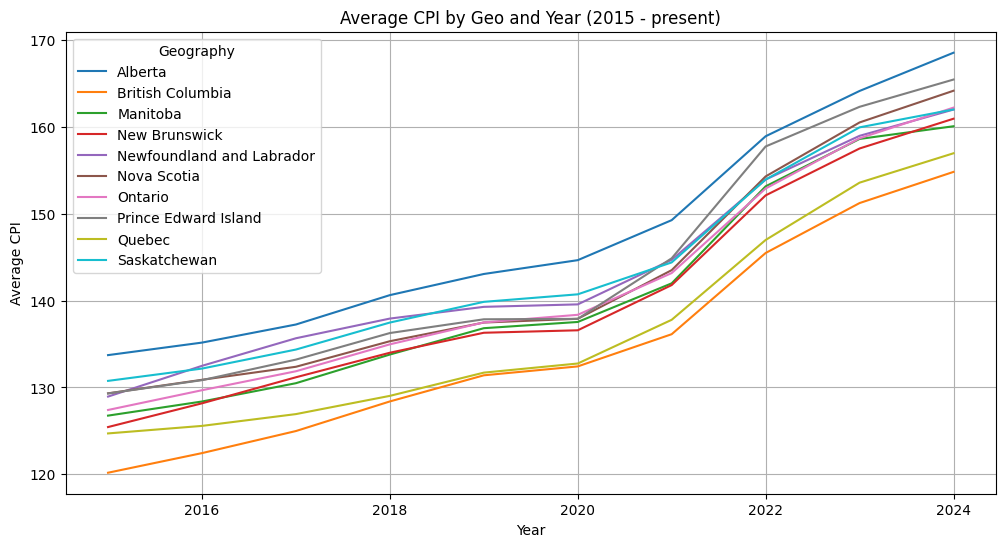

In [589]:
#---------------------- Trend of CPI for Provinces Over Time for the All-Items Product Group (Query_2) ---------------------- #
# line graph for illustation

def create_line_graph_cpi_overall(df):
    if df is not None:
        # Set the figure size
        plt.figure(figsize=(12, 6))

        # Loop through each geo and plot their respective average CPI over the years
        for geo in df['geo'].unique():
            geo_data = df[df['geo'] == geo]
            plt.plot(geo_data['year'], geo_data['avg_cpi'], label=geo)

        # Labeling the graph
        plt.title('Average CPI by Geo and Year (2015 - present)')
        plt.xlabel('Year')
        plt.ylabel('Average CPI')
        plt.legend(title='Geography')
        plt.grid(True)

        # Show the plot
        plt.show()
    else:
        print("Data not available to plot.")
df_2015onwards_filtered = df_Trend_of_CPI_bygeo_year[df_Trend_of_CPI_bygeo_year['year'] >= 2015]

create_line_graph_cpi_overall(df_2015onwards_filtered)

#### 2. Analyzing Inflation Trends Pre-, During-, and Post-COVID (Query_3)

This SQL query calculates the average Consumer Price Index (CPI) for the "All-items" product group across three periods: pre-COVID, during-COVID, and post-COVID. Using three subqueries to compute the average CPI for each period by geographical area (geo). NExt, calculating the percentage changes between these periods (pre to during, during to post, and pre to post). The final output is ordered by the percentage change from "during-COVID" to "pre-COVID" in descending order, showing inflation trends across provinces.

Showing a line graph of the CPI value for each province, along with a table showing the percentage change among periods. The results reveal that the percentage change from pre- to during-COVID is significantly higher, reflecting high demand, which, however, is detrimental to citizens. While the CPI also rises post-COVID, the increase is lower than the rise seen from pre- to during-COVID.

In [591]:
#---------------------- QUERY #3 Analyzing Inflation Trends Pre-, During-, and Post-COVID ---------------------- #

def fetch_data_covid_trend(db_name):
    try:
        connection = mysql.connector.connect(
            host="localhost",
            #user="student",
            user="root",
            password=PASSWORD,
            database=db_name
        )
        
        cursor = connection.cursor()
        insert_query = f"""
          WITH pre_covid AS (
                SELECT geo, products_and_product_groups, AVG(value) AS avg_cpi_pre
                FROM cpi
                WHERE year < '2020'
                AND products_and_product_groups = 'All-items'
                AND geo_level LIKE '%200%'
                GROUP BY geo, products_and_product_groups
            ),
            during_covid AS (
                SELECT geo, products_and_product_groups, AVG(value) AS avg_cpi_during
                FROM cpi
                WHERE year BETWEEN '2020' AND '2022'
                AND products_and_product_groups = 'All-items'
                AND geo_level LIKE '%200%'
                GROUP BY geo, products_and_product_groups
            ),
            post_covid AS (
                SELECT geo, products_and_product_groups, AVG(value) AS avg_cpi_post
                FROM cpi
                WHERE year > '2022'
                AND products_and_product_groups = 'All-items'
                AND geo_level LIKE '%200%'
                GROUP BY geo, products_and_product_groups
            )
            SELECT pc.geo, 
                   pc.avg_cpi_pre, 
                   dc.avg_cpi_during, 
                   post.avg_cpi_post,
                   ROUND((dc.avg_cpi_during - pc.avg_cpi_pre) / pc.avg_cpi_pre * 100, 2) AS during_vs_pre_pct_change,
                   ROUND((post.avg_cpi_post - dc.avg_cpi_during) / dc.avg_cpi_during * 100, 2) AS post_vs_during_pct_change,
                   ROUND((post.avg_cpi_post - pc.avg_cpi_pre) / post.avg_cpi_post * 100, 2) AS post_vs_pre_pct_change
            FROM pre_covid pc
            JOIN during_covid dc 
                ON pc.geo = dc.geo AND pc.products_and_product_groups = dc.products_and_product_groups
            JOIN post_covid post
                ON pc.geo = post.geo AND pc.products_and_product_groups = post.products_and_product_groups
            ORDER BY during_vs_pre_pct_change DESC;
            """               
        cursor.execute(insert_query)
        results = cursor.fetchall()
        print("Canada Inflation Trends Pre-, During-, and Post-COVID:")
        for result in results:
            print(result)
    
        # Convert the fetched data into a DataFrame
        columns = ['pc.geo', 'pc.avg_cpi_pre', 'dc.avg_cpi_during', 'post.avg_cpi_post', 'during_vs_pre_pct_change', 'post_vs_during_pct_change', 'post_vs_pre_pct_change']
        df = pd.DataFrame(results, columns=columns)
        
        return df
       
    except Error as e:
        print("Error:", e)
    finally:
        if connection.is_connected():
            cursor.close()
            connection.close()

df_covid_trend = fetch_data_covid_trend("student")


Canada Inflation Trends Pre-, During-, and Post-COVID:
('Alberta', 120.46375013987223, 150.94999991522894, 166.02857171921502, 25.31, 9.99, 27.44)
('Manitoba', 115.59500007629394, 144.2305556403266, 159.24285670689173, 24.77, 10.41, 27.41)
('Ontario', 116.11791664759318, 144.81666734483508, 160.2047605968657, 24.72, 10.63, 27.52)
('Saskatchewan', 117.66041634877523, 146.35555436876086, 160.83333405994233, 24.39, 9.89, 26.84)
('Newfoundland and Labrador', 117.52874984741212, 146.06944486829968, 160.27142842610678, 24.28, 9.72, 26.67)
('Prince Edward Island', 118.21666657129923, 146.8416667514377, 163.66190447126115, 24.21, 11.45, 27.77)
('New Brunswick', 115.76999982198079, 143.49722290039062, 158.98571414039247, 23.95, 10.79, 27.18)
('Nova Scotia', 117.5258331934611, 145.23888863457574, 162.08095223563058, 23.58, 11.6, 27.49)
('British Columbia', 113.07333319981893, 138.0138897365994, 152.77142987932478, 22.06, 10.69, 25.99)
('Quebec', 114.49083318710328, 139.17777803209094, 155.033331

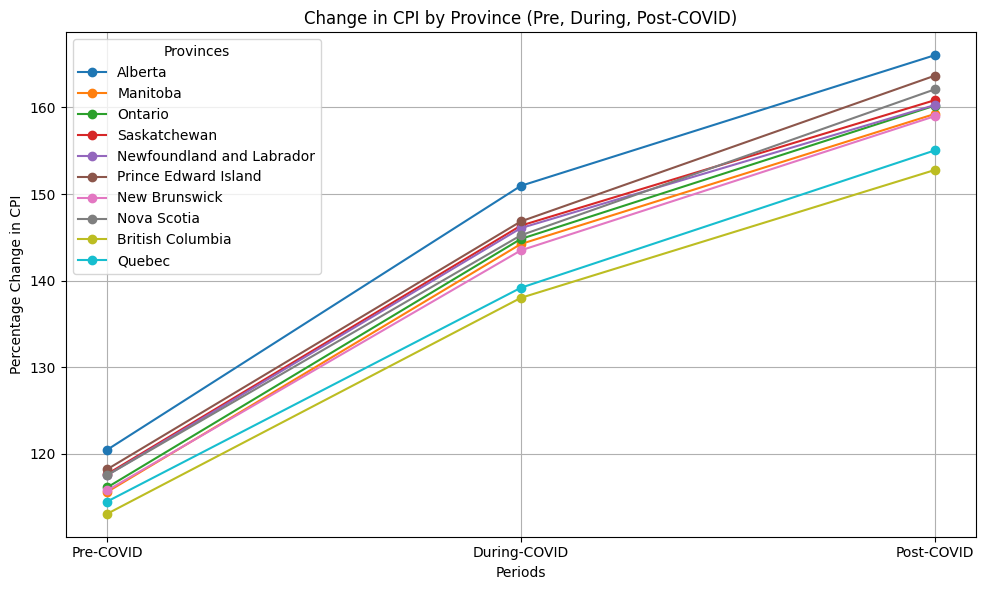

,Province,During vs Pre % Change,Post vs During % Change,Post vs Pre % Change
0,Alberta,25.31,9.99,27.44
1,Manitoba,24.77,10.41,27.41
2,Ontario,24.72,10.63,27.52
3,Saskatchewan,24.39,9.89,26.84
4,Newfoundland and Labrador,24.28,9.72,26.67
5,Prince Edward Island,24.21,11.45,27.77
6,New Brunswick,23.95,10.79,27.18
7,Nova Scotia,23.58,11.60,27.49
8,British Columbia,22.06,10.69,25.99
9,Quebec,21.56,11.39,26.15


In [593]:
#---------------------- QUERY #3 Analyzing Inflation Trends Pre-, During-, and Post-COVID ---------------------- #
# line graph for illustation

def create_line_graph_covid(df):
    if df is not None:
        # Set the figure size
        plt.figure(figsize=(10, 6))
        
        for index, row in df.iterrows():
            plt.plot(['Pre-COVID', 'During-COVID', 'Post-COVID'], 
                     [row['pc.avg_cpi_pre'], row['dc.avg_cpi_during'], row['post.avg_cpi_post']], 
                     label=row['pc.geo'], marker='o')
        
        # Adding titles and labels
        plt.title('Change in CPI by Province (Pre, During, Post-COVID)')
        plt.xlabel('Periods')
        plt.ylabel('Percentage Change in CPI')
        plt.legend(title="Provinces")
        
        # Show the plot
        plt.grid(True)
        plt.tight_layout()
        plt.show()
        
    else:
        print("Data not available to plot.")

create_line_graph_covid(df_covid_trend)


# Display the table
df_covid_trend_table = df_covid_trend.loc[:, ['pc.geo', 'during_vs_pre_pct_change', 'post_vs_during_pct_change', 'post_vs_pre_pct_change']]

df_covid_trend_table.rename(columns={
    'pc.geo': 'Province',
    'during_vs_pre_pct_change': 'During vs Pre % Change',
    'post_vs_during_pct_change': 'Post vs During % Change',
    'post_vs_pre_pct_change': 'Post vs Pre % Change'
}, inplace=True)

df_covid_trend_table


#### 3. Impact of Inflation on Essential vs Non-Essential Products (Query_4)

This query is designed to calculate and compare the average CPI for 'Essential' and 'Non-Essential' products across different years, providing insights into inflation trends for both categories over time.

The line graph shows that the inflation rate for Essential products has been increasing significantly over the years (steep slope). This reflects high inflation, which directly impacts citizens. The graph can help increase public awareness, encouraging better financial planning.

In [595]:
#---------------------- QUERY #4 Impact of Inflation on Essential vs Non-Essential Products ---------------------- #

def fetch_data_product_class(db_name):
    try:
        connection = mysql.connector.connect(
            host="localhost",
            #user="student",
            user="root",
            password=PASSWORD,
            database=db_name
        )
        
        cursor = connection.cursor()
        insert_query = f"""
        WITH product_classification AS (  
            SELECT DISTINCT products_and_product_groups, year,
               CASE 
                   WHEN products_and_product_groups IN ('Food', 'Shelter', 'Energy', 'Health and personal care') THEN 'Essential'
                   WHEN products_and_product_groups IN ('Recreation', 'Toys, games (excluding video games) and hobby supplies', 'Alcoholic beverages, tobacco products and recreational cannabis', 'Travel services') THEN 'Non-Essential'
               END AS category
            FROM cpi
            WHERE products_and_product_groups IN ('Food', 'Shelter', 'Energy', 'Health and personal care','Recreation', 'Toys, games (excluding video games) and hobby supplies', 'Alcoholic beverages, tobacco products and recreational cannabis', 'Travel services')
            )
            SELECT pc.category, d.year , AVG(d.value) AS avg_cpi
            FROM cpi d
            JOIN product_classification pc ON d.products_and_product_groups = pc.products_and_product_groups
            GROUP BY pc.category, d.year
            ORDER BY d.year, avg_cpi DESC;
            """               
        cursor.execute(insert_query)
        results = cursor.fetchall()
        print("Inflation on Essential vs Non-Essential Products by year:")
        for result in results:
            print(result)
    
        # Convert the fetched data into a DataFrame
        columns = ['category', 'year', 'avg_cpi']
        df = pd.DataFrame(results, columns=columns)
        
        return df
       
    except Error as e:
        print("Error:", e)
    finally:
        if connection.is_connected():
            cursor.close()
            connection.close()

df_product_class = fetch_data_product_class("student")


Inflation on Essential vs Non-Essential Products by year:
('Essential', 2000, 96.67205884409886)
('Non-Essential', 2000, 92.24395820299785)
('Essential', 2001, 99.34546576294244)
('Non-Essential', 2001, 94.59395833015442)
('Essential', 2002, 99.99803922690597)
('Non-Essential', 2002, 99.99791661898296)
('Essential', 2003, 103.47916676016415)
('Non-Essential', 2003, 102.68937498728434)
('Essential', 2004, 106.57205876182107)
('Non-Essential', 2004, 103.73000003496806)
('Essential', 2005, 111.24325969172459)
('Non-Essential', 2005, 103.30541658401489)
('Essential', 2006, 114.77806366191192)
('Non-Essential', 2006, 103.73208327293396)
('Essential', 2007, 118.59877452663346)
('Non-Essential', 2007, 106.22562489509582)
('Essential', 2008, 125.68296591440837)
('Non-Essential', 2008, 108.0141665617625)
('Essential', 2009, 123.45686260859172)
('Non-Essential', 2009, 109.40124969482422)
('Essential', 2010, 126.32843151279525)
('Non-Essential', 2010, 110.93625014623007)
('Essential', 2011, 132.2

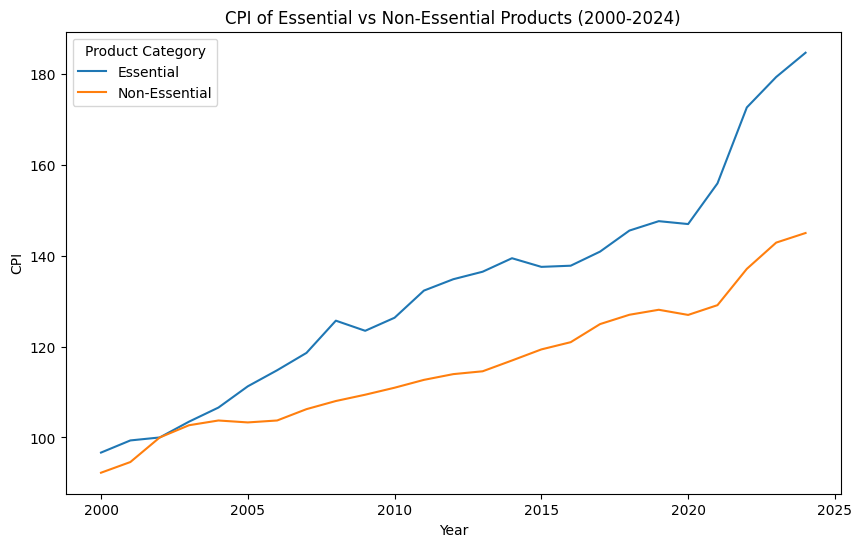

In [597]:
#---------------------- QUERY #4 Impact of Inflation on Essential vs Non-Essential Products ---------------------- #
# line graph for illustation

def create_line_graph_prod_class(df):
    if df is not None:

        plt.figure(figsize=(10, 6))
        
        # Plot CPI for Essential and Non-Essential over the years
        for category in df['category'].unique():
            subset = df[df['category'] == category]
            plt.plot(subset['year'], subset['avg_cpi'], label=category)
        
        # Add labels and title
        plt.xlabel('Year')
        plt.ylabel('CPI')
        plt.title('CPI of Essential vs Non-Essential Products (2000-2024)')
        plt.legend(title='Product Category')
        
    else:
        print("Data not available to plot.")

create_line_graph_prod_class(df_product_class)

#### 4. Exploration of CPI Trends for Products Relevant to Students (Query_5): 

This SQL query calculates the average Consumer Price Index (CPI) for four specific product groups — 'Tuition fees', 'Public transportation', 'School textbooks and supplies', and 'Food' — over different years.

The graph shows that the CPI for tuition fees has been quite stable in its rise, while public transportation fluctuates. The CPI for food has recently experienced a higher increasing rate, as seen from the steep slope in recent years. Appealingly, school textbooks and supplies have shown a relatively stable trend, with the lowest rate of increase year to year.

In [599]:
#---------------------- QUERY #5 Exploration of CPI Trends for Products Relevant to Students ---------------------- #

def fetch_data_student_product(db_name):
    try:
        connection = mysql.connector.connect(
            host="localhost",
            #user="student",
            user="root",
            password=PASSWORD,
            database=db_name
        )
        
        cursor = connection.cursor()
        insert_query = f"""
            SELECT products_and_product_groups, 
                   year,
                   AVG(value) AS avg_cpi
            FROM cpi
            WHERE products_and_product_groups IN ('Tuition fees', 'Public transportation', 'School textbooks and supplies', 'Food')
            GROUP BY products_and_product_groups, year
            ORDER BY products_and_product_groups, year;
            """               
        cursor.execute(insert_query)
        results = cursor.fetchall()
        print("CPI Trends for Products Relevant to Students:")
        for result in results:
            print(result)
    
        # Convert the fetched data into a DataFrame
        columns = ['product', 'year', 'avg_cpi']
        df = pd.DataFrame(results, columns=columns)
        
        return df
       
    except Error as e:
        print("Error:", e)
    finally:
        if connection.is_connected():
            cursor.close()
            connection.close()

df_student_product = fetch_data_student_product("student")


CPI Trends for Products Relevant to Students:
('Food', 2000, 93.96410272060297)
('Food', 2001, 97.53653834416316)
('Food', 2002, 99.99615395374788)
('Food', 2003, 101.55769245441144)
('Food', 2004, 103.39230752602602)
('Food', 2005, 106.00448715992464)
('Food', 2006, 108.50128188500038)
('Food', 2007, 111.52692276392227)
('Food', 2008, 115.42051295745067)
('Food', 2009, 121.41346139174242)
('Food', 2010, 123.08461565849109)
('Food', 2011, 127.71794866904234)
('Food', 2012, 131.03076890798715)
('Food', 2013, 133.008333108364)
('Food', 2014, 136.11538451757187)
('Food', 2015, 141.380128126878)
('Food', 2016, 143.71410262279022)
('Food', 2017, 143.12692329211112)
('Food', 2018, 144.54935885698367)
('Food', 2019, 148.97435916998447)
('Food', 2020, 152.04743546705978)
('Food', 2021, 155.62692397680038)
('Food', 2022, 169.24358993921524)
('Food', 2023, 182.57948733598758)
('Food', 2024, 187.998291276459)
('Public transportation', 2000, 92.63974365821251)
('Public transportation', 2001, 94.40

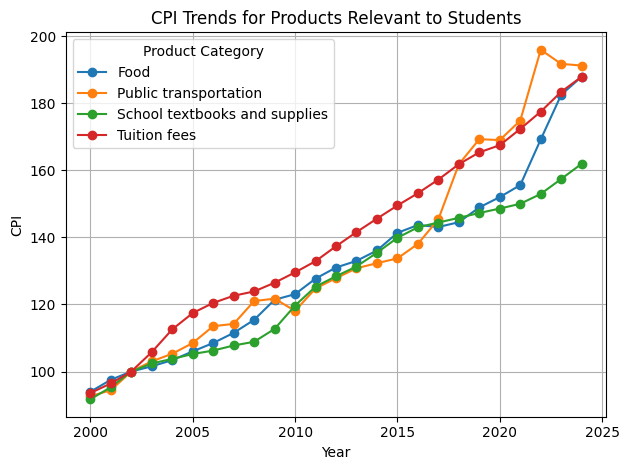

In [601]:
#---------------------- QUERY #4 Impact of Inflation on Essential vs Non-Essential Products ---------------------- #
# line graph for illustation

def create_line_graph_student_prod(df):
    if df is not None:
        
        # Pivot data for plotting
        pivot_df = df.pivot(index="year", columns="product", values="avg_cpi")
        #plt.figure(figsize=(15, 12))
        pivot_df.plot(kind="line", marker="o")
        plt.title("CPI Trends for Products Relevant to Students")
        plt.xlabel("Year")
        plt.ylabel("CPI")
        plt.grid(True)
        plt.legend(title="Product Category")
        plt.tight_layout()
        
        plt.show()
        
    else:
        print("Data not available to plot.")

create_line_graph_student_prod(df_student_product)